In [1]:
import os
import pandas as pd
from mapbox import Geocoder
from mapboxgl.utils import *
from mapboxgl.viz import *
from IPython.display import Image

# Geospatial Intelligence

### Objective
- The objective of this notebook is to map the location of campaign donors and interest groups for Karen Spilka (MA), Liz Krueger (NY), and Ana Rodriguez (FL). To achieve this, we have created two interactive maps, one for each category. 

### Limitations
-  Due to limitations on Github, the interactive maps are turned into static HTML and can only be used when running the notebook locally. Furthermore, since we use the Mapbox API to create the maps, it's necessary to use your own Mapbox access token. To address these issues, we have also created static maps that can be easily displayed.
- We removed all individual donors from the donation data and retained only donations from companies and organizations. The reason behind this is that it's often challenging to identify the address of individual donors. As a result, after this data processing step, the number of donors for Karen and Liz decreased significantly compared to Ana's, as many of Ana's donors donated under the name of companies.
- We utilized Mapbox's Geocoder API to retrieve the geographical coordinates of each entity in bulk. It's worth noting that a single donor may have multiple addresses, and we only selected the first address that appeared. However, this approach may lead to discrepancies from reality, such as situations where donors for these three politicians are present in other states beyond FL, NY, and MA.

In [2]:
os.environ['MAPBOX_ACCESS_TOKEN'] = 'YOUR ACCESS TOKEN'
token = os.getenv('MAPBOX_ACCESS_TOKEN')
geocoder = Geocoder(access_token=token)

donation_df = pd.read_csv('processed_data/geoint_donor.csv')
rating_df = pd.read_csv('processed_data/geoint_interest_group.csv')

In [3]:
def fetch_coordinates(org_name:str) -> tuple:
    response = geocoder.forward(org_name)
    latitude = response.geojson()['features'][0]['geometry']['coordinates'][1]
    longitude = response.geojson()['features'][0]['geometry']['coordinates'][0]
    return latitude, longitude

def create_coordinates_df(original_df:pd.DataFrame, operation:callable, feature:str) -> pd.DataFrame:
    coordinates = original_df[feature].apply(operation)
    new_df = pd.DataFrame(coordinates.tolist(), columns=['lat', 'lon'])
    coordinates_df = original_df.join(new_df)
    return coordinates_df

donation_coordinates = create_coordinates_df(donation_df, fetch_coordinates, feature='donor')
rating_coordinates = create_coordinates_df(rating_df, fetch_coordinates, feature='interest_group')

In [4]:
def visualize_map(df:pd.DataFrame, feature:str, token:str):

    if feature=='donor':
        feature2 = 'donation amount'
        df = df.rename(columns={'weight': feature2})
        property_list = [feature, 'politician', feature2]
    else:
        feature2 = 'rating'
        df = df.rename(columns={'weight': feature2})
        property_list = [feature, 'politician', feature2]
    
    # Create a geojson file from a Pandas dataframe
    points = df_to_geojson(df, 
                properties=property_list,
                lat='lat', lon='lon')

    # Generate data breaks and color stops from colorBrewer
    color_breaks = [0,10,100]
    color_stops = create_color_stops(color_breaks, colors='YlGnBu')

    # Create the viz from the dataframe
    # viz = CircleViz(points,
    #                 access_token=token,
    #                 height='400px',
    #                 color_property=feature2,
    #                 color_stops=color_stops,
    #                 label_property=feature2,
    #                 center=(-95, 40),
    #                 zoom=3,
    #                 below_layer='waterway-label',
    #                 add_snapshot_links=True
    #                 )
    viz = ClusteredCircleViz(points,
                            access_token=token,
                            color_stops=color_stops,
                            radius_stops=[[1,5], [10, 10], [50, 15], [100, 20]],
                            radius_default=2,
                            cluster_maxzoom=10,
                            cluster_radius=30,
                            label_size=12,
                            opacity=0.9,
                            center=(-95, 40),
                            zoom=3,
                            add_snapshot_links=True
                            )
    viz.show()

In [5]:
# Interative Donation Map
visualize_map(donation_coordinates, 'donor', token)

c:\Users\keo57\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [6]:
# Interative Interest Group Map
visualize_map(rating_coordinates, 'interest_group', token)

## Static Donation Map
- For visualization purposes, we utilize clustering to represent the overall donation. Each circle on the map displays the number of donors within its coverage area, and the color of the circle indicates the density of donations. The darker the color, the higher the density of donations in that area.
- From the map, we can see that Ana (FL) has more donors. She has 36 donors in her jurisdiction in Miami, and 53 donors throughout Florida. Liz (NY) has only 9 donors, while Karen (MA) has only 2. This is as expected because Liz and Karen's donors mostly donate as individuals and do not prefer to link their company or organization names with political figures. Therefore, it leads to a relatively small number of donors shown on the map for them.

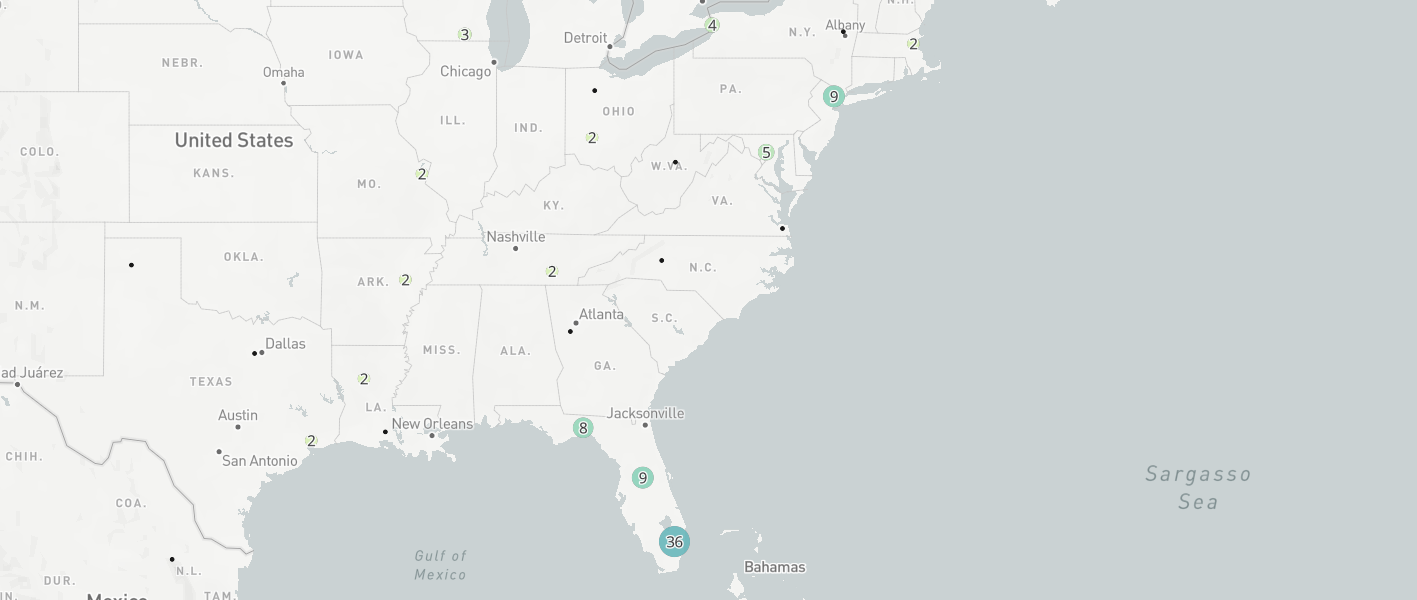

In [7]:
Image(filename='processed_data\maps\donation_map.png') 

## FL Donation Map
- As seen in the map, the majority of Ana's donors are concentrated around Miami.

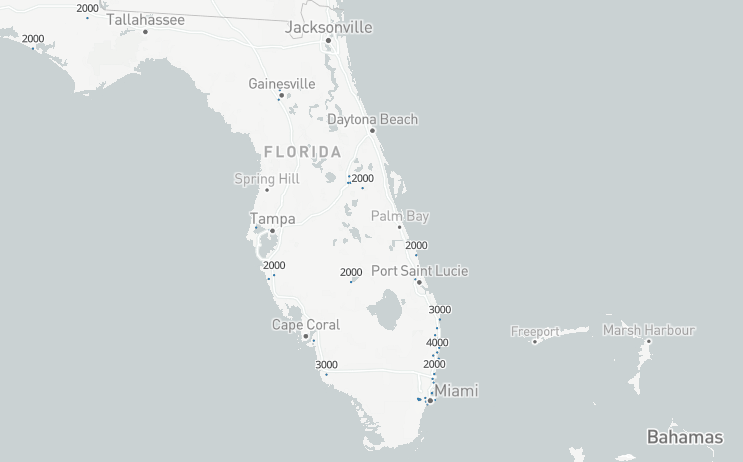

In [8]:
Image(filename='processed_data/maps/fl_donation.png') 

## FL Popup
- This image showcases that by clicking on a donor on our interactive map, a popup card will appear displaying the name of the donor and the donation amount.

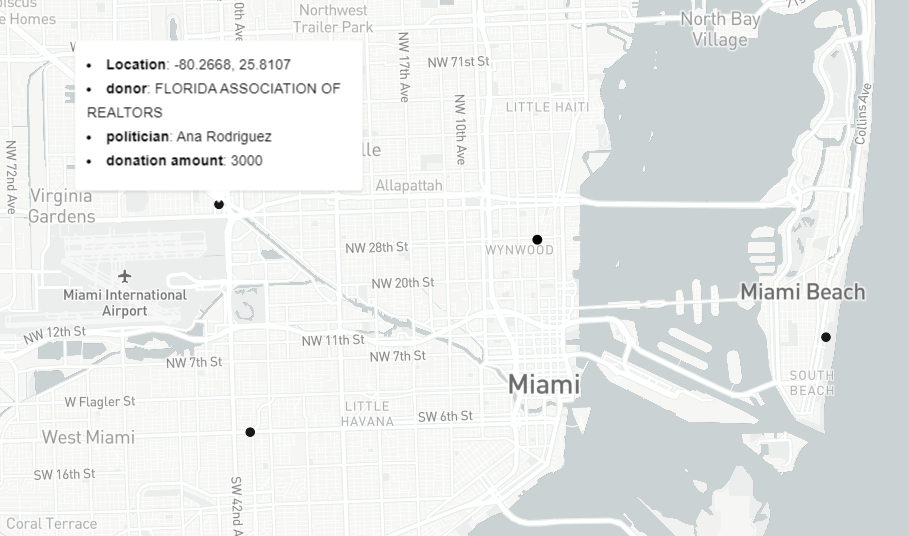

In [9]:
Image(filename='processed_data/maps/fl_popup.png') 

## Static Interest Group Map
- As expected, most of these political organizations are located in the Northeast, as it has been a politically active region throughout history, including New York, Massachusetts, and Washington, D.C. These organizations have a nationwide impact.

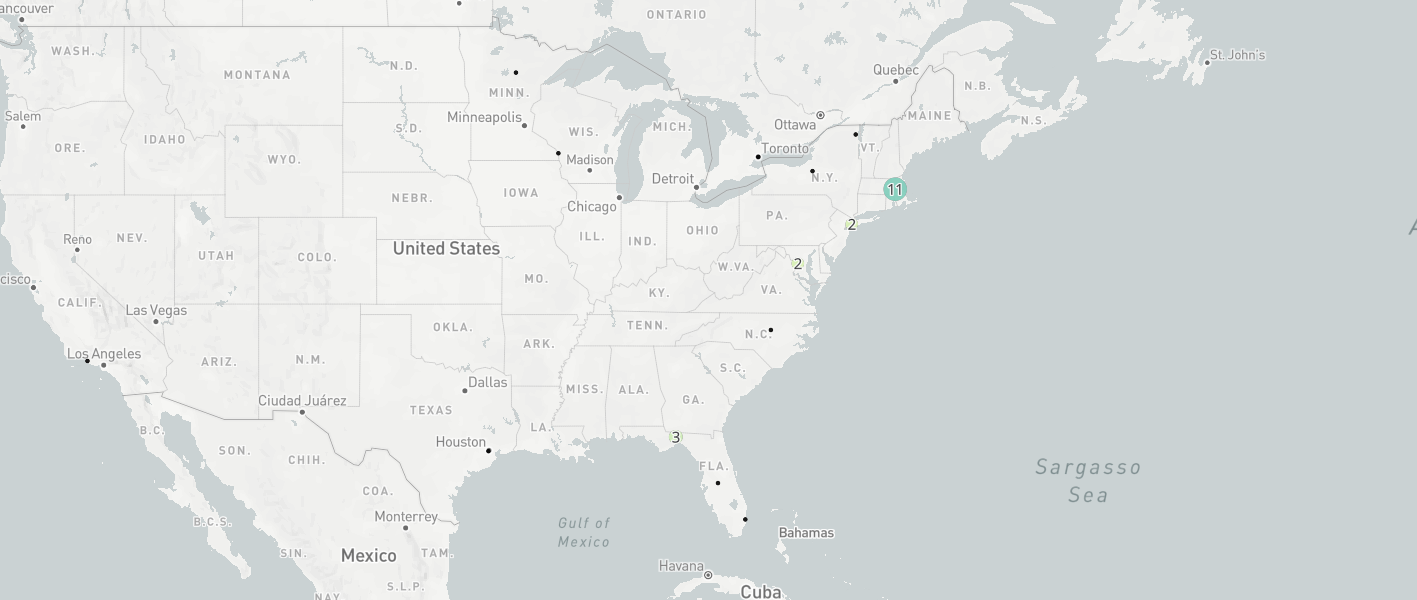

In [10]:
Image(filename='processed_data\maps\interest_group_map.png') 